# 0 Setup

In [2]:
import pandas as pd
import tqdm as tqdm
from pyflightdata import FlightData
import matplotlib.pyplot as plt

In [3]:

# Load the data
file_path = 'data/IVDA_A3_2024_Company_FlightData.csv'  # Replace with your actual file path
data = pd.read_csv(file_path, sep=';')


In [4]:
print(len(data['Flight number'].unique()))

2299


In [5]:
# Setup of a "data_trips" Dataframe, containing all individual trips
data_trips = data[["Flight number", "Aircraft type", "Segments", "Service class", "Department"]]

# Setup of a "data_flights" Dataframe, containing all flights
data_flights_temp = data[["Flight number", "Departure", "Destination", "Total Distance [km]", "CO2 RFI 2 + emissions jet fuel production 15.2% [t]"]]
data_flights = data_flights_temp.drop_duplicates(subset='Flight number', keep='last') # As the whole dataset only has about 2k unique flight numbers, the rest can be dropped.


# 1 Reduction of missing data of departure and destination - 4 points

In [6]:
# Check for missing values
missing_values = data_flights[['Departure', 'Destination']].isna().sum()
print(missing_values)


Departure      1029
Destination    1029
dtype: int64


In [9]:
fd = FlightData()

# flight = fd.get_history_by_flight_number('LX1266')

# print(flight[-1])
# print(flight[0])


# print(flight[-1]["airport"]["origin"]["code"]["iata"])
# print(flight[-1]["airport"]["destination"]["code"]["iata"])

In [27]:

def retrieve_missing_info(row):
    if (pd.isnull(row['Departure']) or pd.isnull(row['Destination'])):
        try:
            if len(fd.get_flights(row['Flight number'])) > 0:
                flight_info = fd.get_history_by_flight_number(row['Flight number'])  # Retrieve flight information based on past flights.
                if len(flight_info) > 0:
                    row['Departure'] = flight_info[-1]["airport"]["origin"]["code"]["iata"]  # Adjust this based on actual response structure
                    row['Destination'] = flight_info[-1]["airport"]["destination"]["code"]["iata"]  # Adjust this based on actual response structure
                    print(f"{row.name}/{len(data)}")
        except Exception as e:
            print(f"Error retrieving departure for flight {row['Flight number']}: {e}")
    return row

In [11]:
t1_data_flights = data_flights.apply(retrieve_missing_info, axis=1)

48/2299
54/2299
60/2299
61/2299
63/2299
HTML code 402 - Retry in 10 seconds...
65/2299
69/2299
72/2299
HTML code 402 - Retry in 10 seconds...
78/2299
79/2299
88/2299
89/2299
HTML code 402 - Retry in 10 seconds...
91/2299
95/2299
98/2299
102/2299
HTML code 402 - Retry in 10 seconds...
104/2299
116/2299
120/2299
HTML code 402 - Retry in 10 seconds...
153/2299
156/2299
159/2299
160/2299
203/2299
HTML code 402 - Retry in 10 seconds...
204/2299
HTML code 402 - Retry in 10 seconds...
231/2299
241/2299
256/2299
269/2299
292/2299
HTML code 402 - Retry in 10 seconds...
293/2299
312/2299
321/2299
324/2299
HTML code 402 - Retry in 10 seconds...
339/2299
351/2299
357/2299
360/2299
HTML code 402 - Retry in 10 seconds...
372/2299
377/2299
HTML code 402 - Retry in 10 seconds...
387/2299
HTML code 402 - Retry in 10 seconds...
414/2299
416/2299
417/2299
HTML code 402 - Retry in 10 seconds...
423/2299
424/2299
426/2299
431/2299
432/2299
434/2299
HTML code 402 - Retry in 10 seconds...
498/2299
506/2299
5

Departure      438
Destination    438
dtype: int64


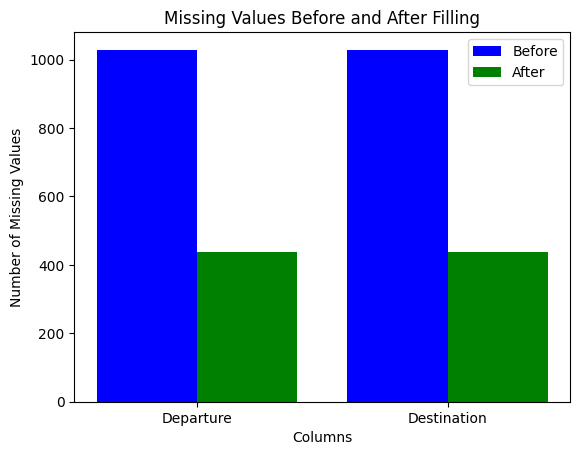

In [14]:

# Plot before filling missing values
missing_before = missing_values

# After filling missing values
missing_after = t1_data_flights[['Departure', 'Destination']].isnull().sum()

print(missing_after)

# Plotting
labels = ['Departure', 'Destination']
before_counts = [missing_before['Departure'], missing_before['Destination']]
after_counts = [missing_after['Departure'], missing_after['Destination']]

x = range(len(labels))

plt.bar(x, before_counts, width=0.4, label='Before', color='blue', align='center')
plt.bar([p + 0.4 for p in x], after_counts, width=0.4, label='After', color='green', align='center')

plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values Before and After Filling')
plt.xticks([p + 0.2 for p in x], labels)
plt.legend()
plt.show()


Before: 1029
After: 438

In [21]:
# Drop rows containing "NaN" in data_flights Dataframe
columns_to_check = ['Departure', 'Destination']
t1_data_flights_cleaned = data_flights.dropna(subset=columns_to_check)

print(len(t1_data_flights_cleaned))

# Save progress to file.
t1_data_flights_cleaned.to_csv('data/t1_FlightData.csv', index=False, sep=';')
data_trips.to_csv('data/t1_TripData.csv', index=False, sep=';')

1861


## 1.1 Reasoning

In a first step it could be observed using ```print(len(data['Flight number'].unique()))``` that there are indeed only 2299 unique flight numbers in this dataset. As the flight number acts as the unique identifier for a flight (as described in the provided "Add-On Info to Flight-related Emissions of a Zurich-based company.pdf"), the dataset could be split into a trips dataset ```data_trips``` and a flights dataset ```data_flights```. From the latter, all duplicates could be dropped, which significantly reduced the effort required to find the missing departure and destination information (shown as "NaN" in pandas).

The Python library ```pyflightdata```, more specifically, its function ```get_history_by_flight_number(flight_number)``` has been used to fetch the missing departure and destination data. ```get_history_by_flight_number(flight_number)``` takes a flight number and returns a list of occurrences of this flight. From this, the destination and departures IATA-codes can be extracted.

>As the function ```get_history_by_flight_number(flight_number)``` returns multiple entries for the same flight ID's with sometimes different destination/departure codes, the last entry to the list was deemed appropriate as the most accurate representation of correct data.

As can be seen in the above bar-chart, the developed function ```retrieve_missing_info()``` was used to iterate over the whole dataset and fill the missing values and the missing data could be significantly reduced from 1029 to 438 (for both departure and destination).

All remaining NaN rows for departure or destination are dropped to not further interfere with upcoming tasks.

# 2 Airport code errors - 1 point

In [28]:
# Load airport data
data_airports = pd.read_csv('data/iata-icao.csv')

# Load your main DataFrame (replace with your actual DataFrame)
data_flights = pd.read_csv('data/t1_FlightData.csv', sep=';')

## 2.1 Find airport code errors

In [29]:
# Convert the valid IATA codes to a set for quick lookup
valid_iata_set = set(data_airports['iata'].str.upper())  # Convert to uppercase for consistency

# Add "IATA-Error" column for tracking
data_flights["IATA-Error"] = 0

# Function to check and correct IATA codes
def check_airport_codes(row):
    if row['Departure'] not in valid_iata_set:
        row['Departure'] = None
        row["IATA-Error"] = 1
    if row['Destination'] not in valid_iata_set:
        row['Destination'] = None
        row["IATA-Error"] = 1
    return row


In [30]:
error_data_before = data_flights.apply(check_airport_codes, axis=1)


## 2.2 Resolving IATA-Errors

In [31]:
def solve_iata_error(row):
    if row['IATA-Error'] == 1:
        try:
            if len(fd.get_flights(row['Flight number'])) > 0:
                flight_info = fd.get_history_by_flight_number(row['Flight number'])  # Retrieve flight information based on past flights.
                if len(flight_info) > 0:
                    row['Departure'] = flight_info[-1]["airport"]["origin"]["code"]["iata"]  # Adjust this based on actual response structure
                    row['Destination'] = flight_info[-1]["airport"]["destination"]["code"]["iata"]  # Adjust this based on actual response structure
                    row['IATA-Error'] = 0
                    print(f"{row.name}/{len(data)}")
        except Exception as e:
            print(f"Error retrieving departure for flight {row['Flight number']}: {e}")
    return row

In [32]:
error_data_after = error_data_before.apply(solve_iata_error, axis=1)

69/7464
443/7464
485/7464
639/7464
1044/7464
1347/7464
1348/7464
1349/7464
HTML code 402 - Retry in 10 seconds...
1354/7464
1355/7464
1409/7464
1454/7464
1522/7464
1556/7464
HTML code 402 - Retry in 10 seconds...
1557/7464
1689/7464
1851/7464
1857/7464


In [33]:
missing_before = (error_data_before['IATA-Error'] == 1).sum()

missing_after = (error_data_after['IATA-Error'] == 1).sum()

print(missing_before)
print(missing_after)

34
16


## 2.3 Plotting airport error development

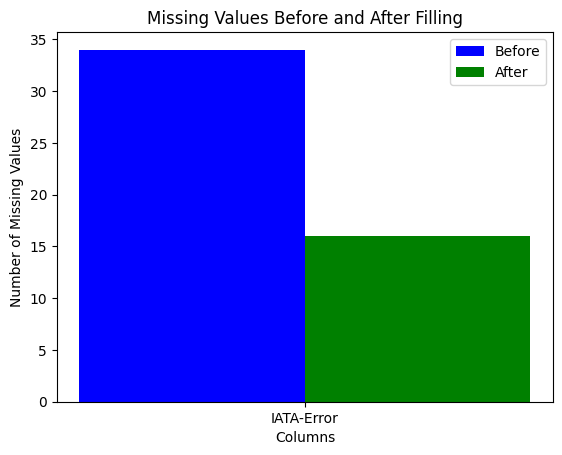

In [34]:
# Plot before filling missing values
missing_before = (error_data_before['IATA-Error'] == 1).sum()

# After filling missing values
missing_after = (error_data_after['IATA-Error'] == 1).sum()

# Plotting
labels = ['IATA-Error']
before_counts = [missing_before]
after_counts = [missing_after]

x = range(len(labels))

plt.bar(x, before_counts, width=0.4, label='Before', color='blue', align='center')
plt.bar([p + 0.4 for p in x], after_counts, width=0.4, label='After', color='green', align='center')

plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values Before and After Filling')
plt.xticks([p + 0.2 for p in x], labels)
plt.legend()
plt.show()

In [50]:
# Drop rows containing "NaN" in data_flights Dataframe
t2_data_flights_cleaned = error_data_after[error_data_after['IATA-Error'] != 1]
t2_data_flights_cleaned = t2_data_flights_cleaned.drop('IATA-Error', axis=1)

print(f"Reduced size from {len(error_data_after)} to {len(t2_data_flights_cleaned)}.")

Reduced size from 1861 to 1845.


In [51]:
# Save the updated DataFrame if needed
t2_data_flights_cleaned.to_csv('data/t2_FlightData.csv', index=False)  # Replace with your desired output path

## 2.4 Reasoning

IATA-codes are known and publicly available information (e.g., https://github.com/ip2location/ip2location-iata-icao/blob/master/iata-icao.csv).

In order to check for errors, the approach was taken to simply compare each IATA-code of the `data_flights` Dataframe with the above-mentioned list (see function `check_airport_codes()`). Each code (no matter because of which error) that doesn't appear on this list is considered faulty and flagged with the respective column "IATA-Error".

In a second step, the function `solve_iata_error()` checks each flagged row and resolves it by fetching the correcti information from the `pyflightdata` function `get_history_by_flight_number(flight_number)`, as similarly done in step 1.

Through this, a significant improvement can be seen: from ... errors to ...

All remaining error rows are dropped to not further interfere with upcoming tasks.

# 3 Derive latitude and longitude- 1 point

In [52]:
# Load your main DataFrame
data_flights = pd.read_csv('data/t2_FlightData.csv')

# Load airport data
airport_data = pd.read_csv('data/iata-icao.csv')

Index(['Flight number', 'Departure', 'Destination', 'Total Distance [km]',
       'CO2 RFI 2 + emissions jet fuel production 15.2% [t]'],
      dtype='object')


In [53]:
# Initialize new columns with None
data_flights['dep_lat'] = None
data_flights['dep_lon'] = None
data_flights['dest_lat'] = None
data_flights['dest_lon'] = None

In [54]:
def get_lat_long_by_iata(iata_code, df):
    """Retrieve latitude and longitude for a given IATA code."""
    # Filter the DataFrame for the given IATA code
    airport_info = df[df['iata'].str.upper() == iata_code.upper()]

    if not airport_info.empty:
        # Extract latitude and longitude
        latitude = airport_info['latitude'].values[0]
        longitude = airport_info['longitude'].values[0]
        return latitude, longitude
    else:
        return None, None  # Return None if IATA code is not found

In [55]:
# Iterate through the main DataFrame and fill the new columns
for index, row in data_flights.iterrows():
    if pd.isna(row['Departure']) or pd.isna(row['Destination']):
        pass
    else:
        dep_iata = row['Departure']
        dest_iata = row['Destination']
        
        # Get latitude and longitude for the departure IATA code
        dep_lat, dep_long = get_lat_long_by_iata(dep_iata, airport_data)
        data_flights.at[index, 'dep_lat'] = dep_lat
        data_flights.at[index, 'dep_lon'] = dep_long
        
        # Get latitude and longitude for the destination IATA code
        dest_lat, dest_long = get_lat_long_by_iata(dest_iata, airport_data)
        data_flights.at[index, 'dest_lat'] = dest_lat
        data_flights.at[index, 'dest_lon'] = dest_long



In [58]:
missing_values = data_flights[['dep_lat', 'dep_lon', 'dest_lat', 'dest_lon']].isna().sum()
print(missing_values)
print(len(data_flights))

dep_lat     5
dep_lon     5
dest_lat    8
dest_lon    8
dtype: int64
1845


In [59]:
# Drop rows containing "NaN" in data_flights Dataframe for cols latitude & longitude
columns_to_check = ['dep_lat', 'dep_lon', 'dest_lat', 'dest_lon']
t3_data_flights_cleaned = data_flights.dropna(subset=columns_to_check)

print(len(t3_data_flights_cleaned))

1832


In [60]:
# Save the updated DataFrame
t3_data_flights_cleaned.to_csv('data/t3_FlightData.csv', index=False) 

## 3.1 Reasoning
Four new columns in the `data_flights` Dataframe were created to facilitate the storage of latitude & longitude information for both, departure and destination.

The longitude and latitude data was fetched using the provided `iata-icao.csv` (https://github.com/ip2location/ip2location-iata-icao/blob/master/iata-icao.csv).

All remaining NaN rows for latitude & longitude values (wherever they couldn't be fetched) are dropped to not further interfere with upcoming tasks. This was the case for 13 rows.

# 4 Total distance outlier detection- 3 points

In [220]:
# Setup
data_flights = pd.read_csv('data/t3_FlightData.csv')

In [253]:
from geopy.distance import geodesic

main_data["Air Distance"] = 0      

def calc_air_dist(row):
    if pd.isna(row['dep_lat']) or pd.isna(row['dep_lon']):
        row["Air Distance"] = None
    else:
        dep = (row["dep_lat"], row["dep_lon"])
        dest = (row["dest_lat"], row["dest_lon"])
        try:
            row["Air Distance"] = round(geodesic(dep, dest).km)
        except:
            row["Air Distance"] = None
    return row


In [254]:
tmp_dist_data_before = main_data.apply(calc_air_dist, axis=1)

In [255]:
missing_before = (tmp_dist_data_before['Air Distance'] == 0).sum()

print(missing_before)

7


In [256]:
print(tmp_dist_data_before.iloc[5000])

Flight number                                              LX8
Aircraft type                                              NaN
Departure                                                  ZRH
Destination                                                ORD
Segments                                                   1.0
Service class                                                Y
Total Distance [km]                                     7253.0
CO2 RFI 2 + emissions jet fuel production 15.2% [t]        NaN
Department                                               Sales
IATA-Error                                                   0
dep_lat                                                47.4647
dep_lon                                                8.54917
dest_lat                                               41.9786
dest_lon                                              -87.9047
Air Distance                                            7150.0
Name: 5000, dtype: object


## 4.1 Visualization of distribution

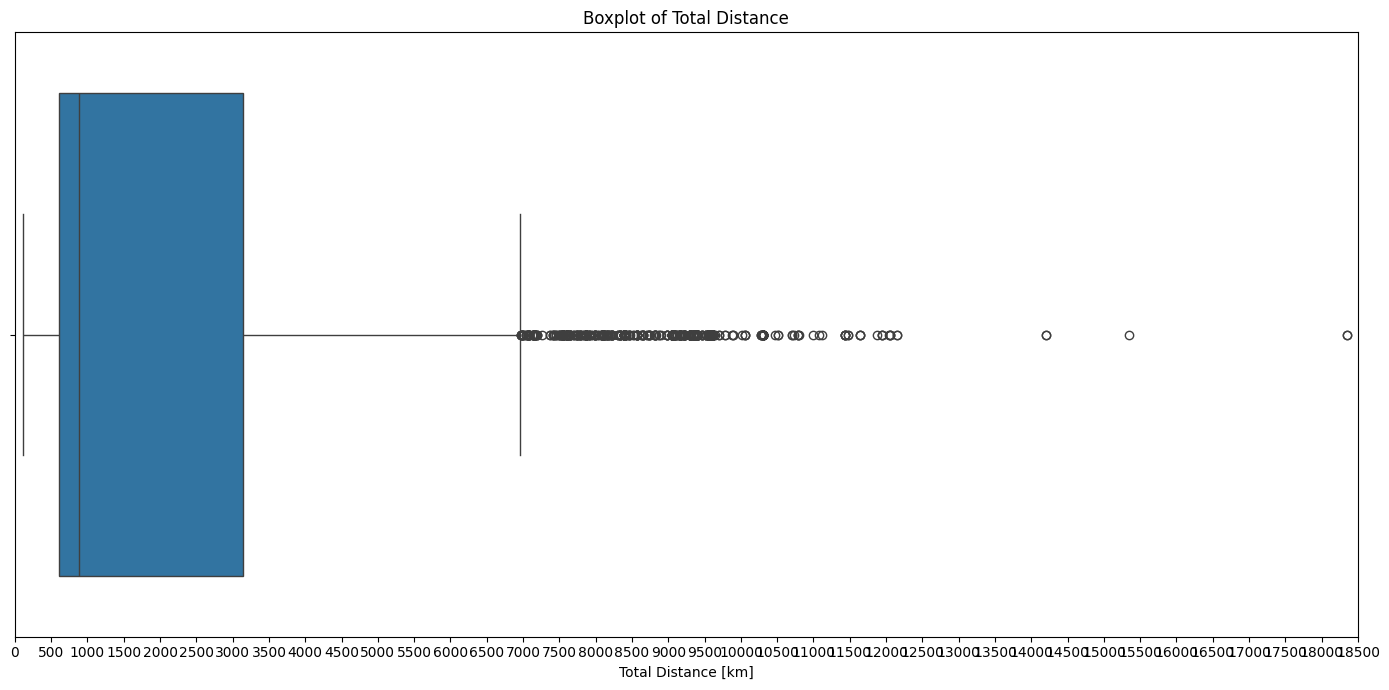

In [248]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Filter out values that are 0 or None (NaN)
tmp_dist_data_before_plot = tmp_dist_data_before[(tmp_dist_data_before['Air Distance'] > 0)]


# Visualize the distribution of Total Distance with improvements
plt.figure(figsize=(14, 7))  # Increase the figure size
sns.boxplot(x='Air Distance', data=tmp_dist_data_before_plot)  # Horizontal boxplot
plt.title('Boxplot of Total Distance')
plt.xlabel('Total Distance [km]')

# Calculate the min and max for the x-axis limits
min_distance = tmp_dist_data_before_plot['Air Distance'].min()
max_distance = tmp_dist_data_before_plot['Air Distance'].max()

# Set x-axis limits based on the data range
plt.xlim(min_distance - (min_distance % 500), max_distance + (500 - (max_distance % 500)))

# Set x-ticks to show whole numbers at 500 km intervals for better readability
tick_positions = np.arange(min_distance // 500 * 500, max_distance // 500 * 500 + 1000, 500)
plt.xticks(tick_positions)

# Ensure that the ticks are in ascending order
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(500))  # Set major ticks at 500 km intervals

# Show the plot
plt.tight_layout()  # Adjust layout to make it look better
plt.show()


In [251]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = tmp_dist_data_before_plot['Air Distance'].quantile(0.25)
Q3 = tmp_dist_data_before_plot['Air Distance'].quantile(0.75)
IQR = Q3 - Q1

# Determine bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

# Identify outliers
outliers = tmp_dist_data_before_plot[(tmp_dist_data_before_plot['Air Distance'] < lower_bound) | 
                     (tmp_dist_data_before_plot['Air Distance'] > upper_bound)]

print(f"Number of outliers detected: {len(outliers)}")


Lower Bound: -3208.375, Upper Bound: 6960.625
Number of outliers detected: 725


# References
